# Application of the Dynamic Ising Model to Chemotactic Receptors 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit

Following the previous notebooks, we now aim to use the Ising model to capture the activity of chemotactic receptor arrays. While we knew what to expect and look for in the Ising model, this part becomes more exploratory, so we shall try different approaches and see what works best for our purposes. Ultimately, we want that our model captures at least two things:

- dynamic range in response to ambient ligand concentration;
- adaptation after a step change in concentration.

For this purpose, we realise that our model should incorporate ligand binding (in order to respond to a changing concentration) and methylation (as a feedback mechanism necessary for adaptation). Naively, we may resort to the idea behind the kinetic MWC model we wrote, where each receptor has a three-component state vector specifying the ligand binding, methylation and activity. In principle, we could think of doing something similar for the Ising model, but this would give a computationally and conceptually complex model. While keeping this option in the back of our mind, we first explore whether there may be a more straightforward approach to incorporate ligand binding and methylation into our model.

Ideas to test:
- incorporate a coupling term into the MWC model (see 'Heightened sensitivity of a lattice of membrane receptors' by Duke & Bray)

## Concentration-dependent External Field

We shall first focus on incorporating ligand concentration into the Ising model. For now, we assume that ligand binding and unbinding are very fast processes, such that the explicit dynamics can be integrated out. This means that only the ambient ligand concentration $c$ matters for the dynamics of our system at the time scale of interest. 

Following Skoge et al. (2011), we incorporate these considerations into the Ising model by letting the external field $H$ depend on the ligand concentration, while we take a slightly different approach than Skoge et al. Concretely, inspired by the MWC model, the free-energy difference $f$ between the active and inactive confirmation per receptor is

$$ f = \epsilon_0 + \log \frac{1 + c/K_D^I}{1 + c/K_D^A}, $$

where $\epsilon_0$ is the energy difference between the active and inactive state in the absence of ligand, and $K_D^{I}$ and $K_D^{A}$ are the dissociation constants for the inactive and active confirmation, respectively. Note that throughout this work, we use units where $k_\text{B} T = 1$ and that this energy does not depend on the activity of a receptor. The total energetic cost from receptors that are in the active rather than inactive state is then

$$ F = f\sum_{i=}^N a_i, $$

where $a_i = 0,1$ denotes the activity variable of receptor $i$. We would like to formulate the Ising model in terms of spin variables, so we rewrite the above as

$$F = f\sum_{i=1}^N\left(\frac{1}{2} + \frac{1}{2}s_i \right) = \frac{1}{2}N f + \frac{1}{2} f \sum_{i=1}^N s_i.$$

We incorporate this into the Ising model through as an external field $-F$, because by our convention, a higher free energy should corresponds to a higher probability of being inactive, which is enforced through this minus sign. The expression for the hamiltonian is then 

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j + \frac{1}{2}N f + \frac{1}{2} f \sum_{i=1}^N s_i. $$

The corresponding flipping rates are

$$ \omega_i = \omega_0 \exp\left\{-J s_i \sum_{(i,j)}s_j + \frac{1}{2} f s_i \right\}. $$

This approach lends itself for a useful interpretation. Concretely, we can view the term in $\epsilon_0$ as a 'bias' for the receptors to be in either an active or inactive confirmation. In fact, at equilibrium, receptors tend to favour the inactive confirmation and $\epsilon_0$ is a parameter that allows us to capture this. Notice that the constant offset in $Nf$ should not affect the dynamics, as these only depend on energy differences between the active and inactive state. Furthermore, based on the above expression, we expect that the system will have a wide dynamic range, as it responds to changes in $\log c$ rather than $c$ itself. As such, this seems like a promising first step in applying the Ising model to bacterial chemotaxis.


In [2]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i] = np.roll(state[i],1)
        right[i] = np.roll(state[i],-1)
        top[:,i] = np.roll(state[i],1)
        bottom[:,i] = np.roll(state[i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

In [3]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ising_2d_lig(n_sims,state0,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):
    # initialise
    state = state0

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state

    # store all waiting times
    waiting_times = np.zeros(n_sims)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # change concentration after some steps
        if k >= step_change:
            c = cnew
        else:
            c = cbase
        
        # define the external field 
        H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
        
        # obtain rates of flipping
        rates = rates_2d_numba(J,H,state)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt
        
        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, waiting_times

We would like to verify that our current model maps well to the original Ising model, from which we know that at equilibrium and without coupling, the average spin satisfies

$$ m = \tanh(H). $$

We translate this to the average activity and with the current expression for the external field as

$$ a = \frac{1}{2} + \frac{1}{2}\tanh\left[-\frac{1}{2}\left(\epsilon_0 + \log \frac{1+c/K_i}{1+c/K_a} \right) \right], $$

so we check whether our simulation and theory agree on this. Furthermore, we have chosen $\epsilon_0$ such that without coupling, the equilibrium activity is 0.5 for a baseline concentration of 100 $
mu$M. The reason is that this makes interpreting the dose-response curves later on a bit more straightforward. We can set $a=1/2$ in the above expression to get

$$ \epsilon_0 = -\log \frac{1+c/K_i}{1+c/K_a}, $$

which we use to determine $\epsilon_0$ at $c=100$ $\mu$M.

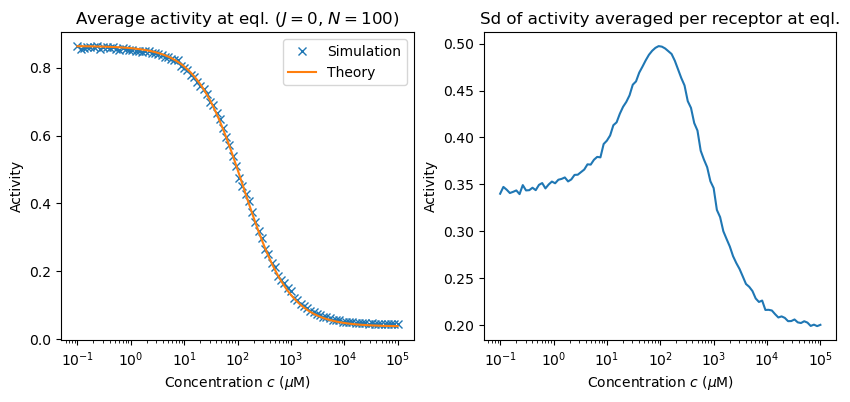

In [4]:
# check how this goes
n_sims = 10**4
L = 10
state0 = np.random.choice([-1.,1.], L**2)
state0 = state0.reshape((L,L))
J = 0

c_arr = np.logspace(-1,5,10**2)
all_avg_spin = np.empty(c_arr.size)
all_std_spin = np.empty(c_arr.size)

# loop through various concentrations
for i,c in enumerate(c_arr):
    # initialise
    state0 = np.random.choice(np.array([-1.,1.]), size=(L,L))
    
    # obtain average magnetisation at equilibrium
    spins, waiting_times = ising_2d_lig(n_sims,state0,L,J,cbase=c)
    std_spin = np.std(spins,axis=(1,2))
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[n_sims//3:])
    all_std_spin[i] = np.mean(std_spin[n_sims//3:])
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin
all_std_act = 0.5*all_std_spin

# check theoretical result
def theoretical_a(c,L,Ki=18,Ka=2900):
    epsilon = -np.log((1+100/Ki)/(1+100/Ka))
    return 0.5 + 0.5*np.tanh(-0.5*(epsilon + np.log((1+c/Ki)/(1+c/Ka))))

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.semilogx(c_arr,all_avg_act,'x',label='Simulation')
ax1.semilogx(c_arr,theoretical_a(c_arr,L),label='Theory')
#ax1.axvline(x=c_crit,ymin=0.05,ymax=0.95,color='r',linestyle=':')
ax1.set_xlabel(r'Concentration $c$ ($\mu$M)')
ax1.set_ylabel('Activity')
ax1.legend()
ax1.set_title(f'Average activity at eql. ($J = {J}$, $N={L**2}$)')

ax2.semilogx(c_arr,all_std_act,label='Average std at eql.')
ax2.set_xlabel(r'Concentration $c$ ($\mu$M)')
ax2.set_ylabel('Activity')
ax2.set_title('Sd of activity averaged per receptor at eql.')

plt.show()

## Phase transition

The above results that even if we only take one measurement per value of $c$, we find excellent agreement between theory and simulation! Do note that for low $c$, the average activity per receptor fluctuates substantially in time. Still, we expect that that the mean has a narrow distribution. Verifying this would require multiple simulations per $c$ to get a sampling distribution. For now, we are happy with our result and move onto to verifying whether the simulation displays a continuous phase transition in $J$. 

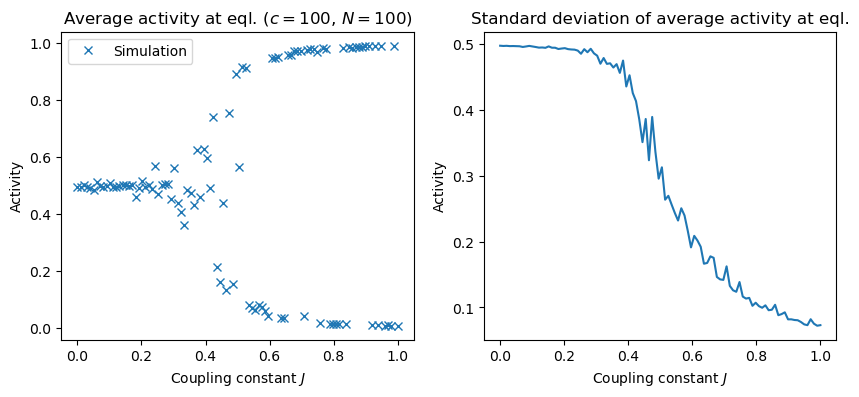

In [5]:
# obtain activity as function of J without external field
# note that by our choice of epsilon0, the external field is zero for c=100
n_sims = 10**4
L = 10
state0 = np.random.choice([-1.,1.], L**2)
state0 = state0.reshape((L,L))
c = 100

J_arr = np.linspace(0,1,10**2)
all_avg_spin = np.empty(J_arr.size)
all_std_spin = np.empty(J_arr.size)

# loop through various concentrations
for i,J in enumerate(J_arr):
    # initialise
    state0 = np.random.choice([-1.,1.], L**2)
    state0 = state0.reshape((L,L))
    
    # obtain average magnetisation at equilibrium
    spins, waiting_times = ising_2d_lig(n_sims,state0,L,J,cbase=c)
    std_spin = np.std(spins,axis=(1,2))
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[n_sims//3:])
    all_std_spin[i] = np.mean(std_spin[n_sims//3:])
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin
all_std_act = 0.5*all_std_spin

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(J_arr,all_avg_act,'x',label='Simulation')
ax1.set_xlabel(r'Coupling constant $J$')
ax1.set_ylabel('Activity')
ax1.legend()
ax1.set_title(f'Average activity at eql. ($c = {c}$, $N={L**2}$)')

ax2.plot(J_arr,all_std_act,label='Average std at eql.')
ax2.set_xlabel(r'Coupling constant $J$')
ax2.set_ylabel('Activity')
ax2.set_title('Standard deviation of average activity at eql.')

plt.show()

## Ensemble averaging

Our previous results indicate that the basic structure of our model seems sensible. For future implementations, it is beneficial to look at ensemble-averaged results. Naively, we would simulate several trajectories and average those. The problem is that the time steps differ per realisation, as these are random variables. Consequently, we need another approach to take an ensemble average. 

Our idea is to have a regularly space grid of time points. Between any two of those time points, we let the simulation run and keep a record of the cumulative waiting times. Once the sum of waiting times crosses the later of the two regular time points, we save the state of the system just before it crossed this time point. In this way, we have regularly spaced times as well as regularly spaced samples of the system's state at each of those times. We can then obtain several realisations in this way and take an ensemble average. 

In [6]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):

    # array to store all results
    all_states = np.zeros((n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over n_samples realisations of the algorithm
    for sample in range(n_samples):
        # initialise each realisation
        dt = 0
        time = 0
        
        # initialise
        state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # flip the spin
                state[m,l] *= -1
                
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
            # save the last state before passing the boundary
            all_states[sample,step,:,:] = state
            
    #################
    ### Averaging ###
    #################
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                ensemble_av[step,spin1,spin2] = np.mean(all_states[:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

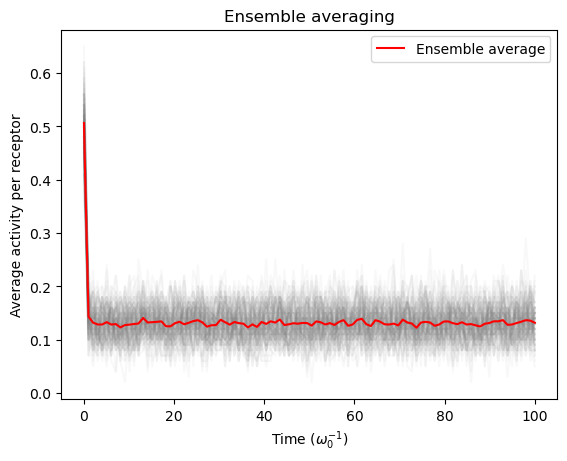

In [7]:
# check whether this works
n_samples = 10**2
n_steps = 10**2
tf = 100
L = 10
J = 0

# obtain results
all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=10**3)

# convert to activity 
ensemble_av_act = 0.5*(ensemble_av + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    plt.plot(t_grid,0.5+0.5*np.mean(all_states[ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)
    
plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),color='red',label='Ensemble average')
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Average activity per receptor')
plt.title('Ensemble averaging')
plt.legend()
plt.show()

## Dose-response curve

A defining feature of cooperative receptors is that they display an S-shaped dose-response curve. We would like to see whether our model captures this behaviour. Intuitively, cooperativity depends strongly on the coupling constant $J$, so we produce a dose-response curve for various values of $J$. This should already reveal what a reasonable value for $J$ is, since we insist that our model can capture cooperative binding. 

We extract the response as follows. The system is simulated from a random initial state with a baseline concentration of 100 $\mu$M. At some timestep (chosen late enough such that the system can equilibrate), we change the concentration for the rest of the simulation. We simulate several trajectories in this way, take an ensemble average over them, and then define the response as the difference between the mean activity before and after the concentration change (where we ignore the transient briefly after the stimulus is presented). 

**TO DO:** use ensemble-averaged Ising

In [8]:
@numba.jit(nopython=True)
def dose_response_curve(n_samples,n_steps,tf,L,J_arr,cnew_arr):
    # set when the concentration is changed
    step_change = int(np.floor(0.4*n_steps))

    # store results
    all_responses = np.zeros((J_arr.size,cnew_arr.size))

    # perform simulation for various J and cnew
    for i,J in enumerate(J_arr):
        # loop for various new concentrations
        for j, c_new in enumerate(cnew_arr):
            # obtain results
            _, ensemble_av, _ = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                                                                      step_change=step_change,cnew=c_new)
                        
            # extract activity, weird numba way
            av_spin = np.sum(np.sum(ensemble_av,axis=-1),axis=-1)/L**2
            activity = 0.5*(av_spin + 1)

            # set baseline and extract new equilibrium
            baseline = np.mean(activity[1000:step_change-1]) # remove transient
            new_act = np.mean(activity[-1000:])

            # save response
            all_responses[i,j] = new_act - baseline
            
    return all_responses

#### Hill coefficient

In addition to plotting the dose-response curve, we would like to quantify the sensitivity of the receptor cluster in a single number. A reasonable choice for this is the Hill coefficient $n_H$. That is, we expect that the dose-response curve for a given value $J$ can be approximated by

$$ \Delta a(c) = \frac{c^{n_H}}{K + c^{n_H}} - \frac{1}{2}  $$

for some apparent dissociation constant $K$. Note that $c$ denotes the final concentration in our procedure for obtaining the response. The Hill coefficient is a measure for the steepness of the dose-response curve. This means that a larger absolute value of $n_H$ indicates a more sensitive receptor cluster. We suspect that this sensitivity depends on how cooperative the receptors are, such that we expect $|n_H|$ to increase with $J$. After all, receptors that act in unison are more likely to pick up on even small environmental changes than a cluster of receptors that react independently to stimuli. 

We added the term $1/2$ by hand. A Hill function has values between 0 and 1, whereas we compute $\Delta a$ with respect to a baseline activity of $1/2$. As such, up to some noise around the baseline level, $\Delta a$ ranges between $1/2$ and $-1/2$, so we shift the Hill function down to accommodate this.

Actually, we can relate $K$ to the baseline concentration $c_0$ we chose. After all, by definition, if the final concentration $c$ equals the initial concentration $c_0$, the response must be zero. Hence, solving the equation $\Delta a(c_0) = 0$ for $K$, we find

$$ K = c_0^{n_H}. $$

Since we fix $c_0 = 100 \, \mu$M, the Hill coefficient remains the only unknown in the expression for $\Delta a$. Still, it is good to verify this theory. Our approach for extracting the Hill coefficients and $K$ is through fitting. That is, once we have obtained the dose-response curve for a given $J$, we fit a Hill function with fitting parameters $n_H$ and $K$ to our simulated data. Repeating this for various $J$ then reveals how $n_H$ (and $K$) depend on $J$. We then plot $K$ versus $n_H$ and compare this with our prediction that $K = 100^{n_H}$. 

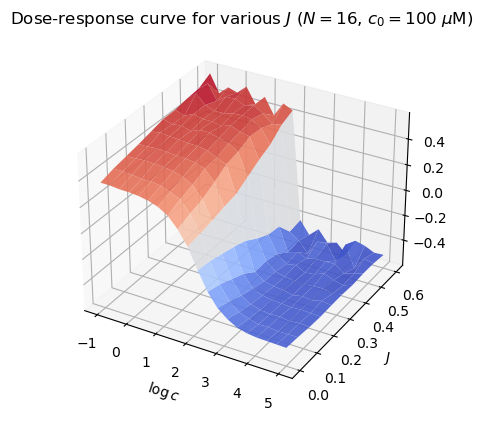

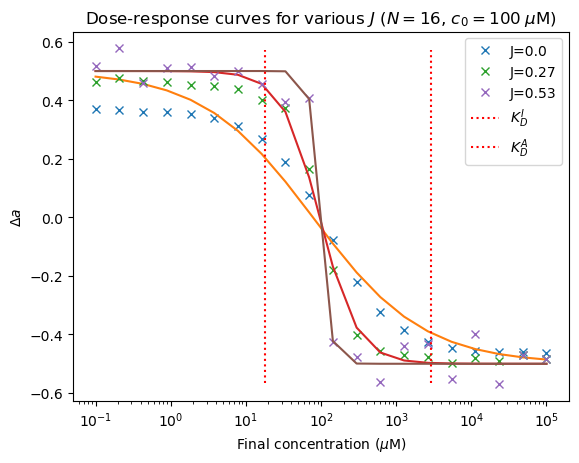

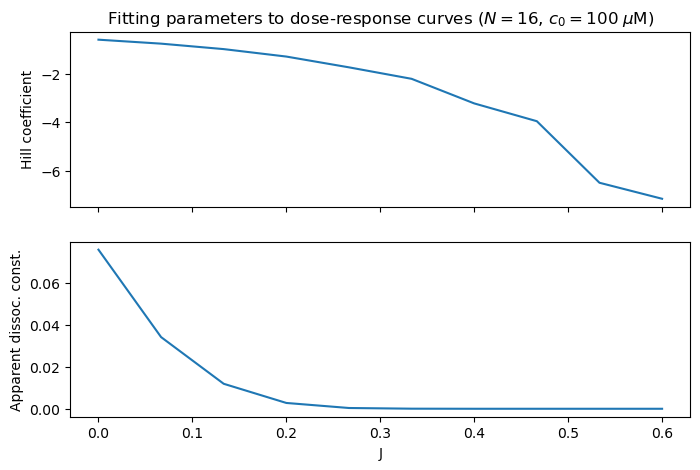

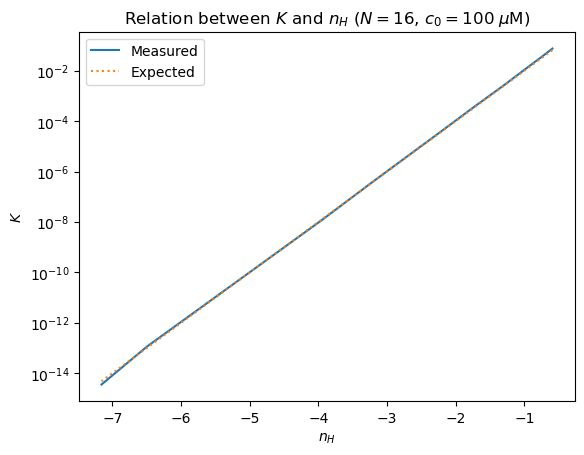

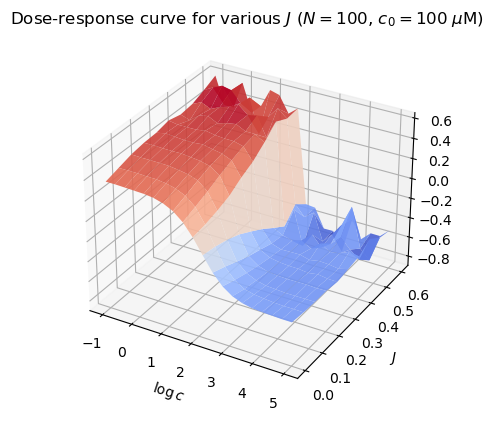

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.

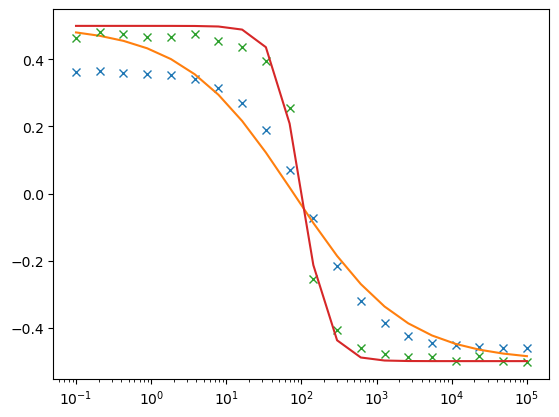

In [9]:
# define Hill function
def hill_func(conc,nH,K):
    return conc**nH/(K + conc**nH) - 0.5

# make a meshgrid for plotting
J_arr = np.linspace(0,0.6,10)
cnew_arr = np.logspace(-1,5,20)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# parameters
n_samples = 10**1
n_steps = 5000
tf = 10**3

# extract dose-response curve for different sizes
for i,L in enumerate([4,10]):
    # array to store fitting parameters and their variances
    parm_arr = np.zeros((2,J_arr.size))
    var_arr = np.zeros_like(parm_arr)

    # extract dose-response curves
    all_responses = dose_response_curve(n_samples,n_steps,tf,L,J_arr,cnew_arr)

    # show results
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(np.log10(c_plot).T, J_plot.T, all_responses,cmap=plt.cm.coolwarm,alpha=0.9,label='Simulation')
    ax.set_xlabel(r'$\log c$')
    ax.set_ylabel('$J$')
    ax.set_title(f'Dose-response curve for various $J$ ($N=${L**2}, $c_0=100 \; \mu$M)')
    plt.show()
    
    # perform fitting
    for j in range(J_arr.size):
        popt, pcov = curve_fit(hill_func,cnew_arr,all_responses[j,:],maxfev=5000)
        parm_arr[:,j] = popt
        var_arr[:,j] = [pcov[k,k] for k in range(2)]
        
        # visual inspection for some results
        if j % 4 == 0:
            plt.semilogx(cnew_arr,all_responses[j,:],'x',label=f'J={np.round(J_arr[j],2)}')
            plt.semilogx(cnew_arr,hill_func(cnew_arr,*popt))
            
    # figure formatting
    plt.axvline(x=18,ymin=0.05,ymax=0.95,label=r'$K_D^I$',linestyle=':',color='r')
    plt.axvline(x=2900,ymin=0.05,ymax=0.95,label=r'$K_D^A$',linestyle=':',color='r')
    plt.xlabel(r'Final concentration ($\mu$M)')
    plt.ylabel(r'$\Delta a$')
    plt.legend()
    plt.title(f'Dose-response curves for various $J$ ($N=${L**2}, $c_0=100 \; \mu$M)')
    plt.show()
    
    # show fitting parameters as functions of J
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,5),sharex=True)
    
    ax1.plot(J_arr,parm_arr[0,:])
    ax1.set_ylabel('Hill coefficient')
    ax1.set_title(f'Fitting parameters to dose-response curves ($N=${L**2}, $c_0=100 \; \mu$M)')
    
    ax2.plot(J_arr,parm_arr[1,:])
    ax2.set_ylabel('Apparent dissoc. const.')
    ax2.set_xlabel('J')
    
    plt.show()
    
    # show the expected relation between the Hill coefficient and K
    plt.semilogy(parm_arr[0,:],parm_arr[1,:],label='Measured')
    plt.semilogy(parm_arr[0,:],10**(2*parm_arr[0,:]),':',label='Expected')
    plt.ylabel(r'$K$')
    plt.xlabel(r'$n_H$')
    plt.legend()
    plt.title(f'Relation between $K$ and $n_H$ ($N=${L**2}, $c_0=100 \; \mu$M)')
    plt.show()

#### Interpretation

Even though we only obtained coarse results for a small cluster, these results are informative. Firstly, the dose-response curves are clearly S-shaped. This means that using a Hill function for fitting is reasonable. Perhaps counterintuitively, the dose-response curve is also S-shaped for $J=0$, meaning that the receptors are cooperative even in the absence of coupling. At first glance, this is a contradiction. However, recall that for ligand binding, we use an MWC-based free-energy difference between the active and inactive state. Cooperativity is assumed in the MWC model, so the receptors are indeed binding ligand cooperatively, even if our coupling constant $J$ is zero. The crux is that we do not model cooperative *ligand binding* explicitly in our model, but rather cooperative *activity switching*. As such, we may disentangle a 'baseline cooperativity' encompassed in the MWC model and an activity-switching cooperativity, which is presumably what we model through $J$. **Conceptually, does this make sense?**

**IDEA: extract the effective Hill coefficient from the MWC model and then fit an exponential model for $n_H$ as a function of $J$, i.e.**

$$n_H = n_H^{MWC}\exp\{J/\chi \}.$$

Indeed, the above results show that for larger $J$, the dose-response curves become steeper. This is a clear sign that the receptors become more cooperative. This makes sense: a higher value of $J$ means that the receptors are more strongly coupled, so if an environmental stimulus flips the activity of some receptors, it is more likely that other receptors will also switch. The receptors respond in unison, allowing the cell to react more sensitively, thus explaining the sharper dose-response curves. 

This is reflected through the increasingly negative Hill coefficient $n_H$ for higher $J$. As mentioned, $|n_H|$ quantifies how sensitive the cluster is. Our results indicate that $|n_H|$ grows more than proportionally with $J$, thus reinforcing the idea that $J$ strongly determines how sensitive the cluster is. 

Finally, we find excellent agreement between the theoretical and measured relation between $K$ and $n_H$. This provides further evidence that the Hill function is an appropriate fitting function for the dose-response curves.

That being said, there is a limitation of the current fitting function. The above results explicitly show that a higher value of $J$ increases the sensitivity (as measured through $n_H$) of the cluster. Yet, another manifestation of cooperativity is the response strength. Indeed, looking at the above data, we notice that the response amplitudes increase as $J$ increases. However, the current fitting function does not capture this. Therefore, we make a slight change,

$$\Delta a(c) = \Delta_{\mathrm{max}} a\left( \frac{c^{n_H}}{c_0^{n_H} + c^{n_H}} - \frac{1}{2} \right). $$

Notice that we replaced $K$ by its theoretical value, just to reduce the number of parameters in our model. We introduced another fitting parameter $\Delta_{\mathrm{max}} a$, which quantifies the strength of the response. Since we start from an average baseline activity of $1/2$, we expect that, on average, the maximum absolute value $\Delta_{\mathrm{max}} a$ can take is $1-1/2 = 1/2$, since the activity is never greater than 1. The question is, however, whether the cell can reach this maximum response, because it would mean that all receptors are (in)active. Presumably, for very large $J$, this may be possible. We use a similar fitting procedure to investigate further how $\Delta_{\mathrm{max}} a$ depends on $J$. 

In [ ]:
# define Hill function
def hill_func_max(conc,delta_a_max,nH):
    return delta_a_max*(conc**nH/(100**nH + conc**nH) - 0.5)        

# make a meshgrid for plotting
J_arr = np.linspace(0,0.6,10)
cnew_arr = np.logspace(-1,5,20)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# parameters
n_samples = 10**1
n_steps = 5000
tf = 10**3

# extract dose-response curve for different sizes
for i,L in enumerate([4,10]):
    # array to store fitting parameters and their variances
    parm_arr = np.zeros((2,J_arr.size))
    var_arr = np.zeros_like(parm_arr)

    # extract dose-response curves
    all_responses = dose_response_curve(n_samples,n_steps,tf,L,J_arr,cnew_arr)

    # show results
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(np.log10(c_plot).T, J_plot.T, all_responses,cmap=plt.cm.coolwarm,alpha=0.9,label='Simulation')
    ax.set_xlabel(r'$\log c$')
    ax.set_ylabel('$J$')
    ax.set_title(f'Dose-response curve for various $J$ ($N=${L**2}, $c_0=100 \; \mu$M)')
    plt.show()
    
    # perform fitting
    for j in range(J_arr.size):
        popt, pcov = curve_fit(hill_func_max,cnew_arr,all_responses[j,:],maxfev=5000)
        parm_arr[:,j] = popt
        var_arr[:,j] = [pcov[k,k] for k in range(2)]
        
        # visual inspection for some results
        if j % 4 == 0:
            plt.semilogx(cnew_arr,all_responses[j,:],'x',label=f'J={np.round(J_arr[j],2)}')
            plt.semilogx(cnew_arr,hill_func_max(cnew_arr,*popt))
            
    # figure formatting
    plt.axvline(x=18,ymin=0.05,ymax=0.95,label=r'$K_D^I$',linestyle=':',color='r')
    plt.axvline(x=2900,ymin=0.05,ymax=0.95,label=r'$K_D^A$',linestyle=':',color='r')
    plt.xlabel(r'Final concentration ($\mu$M)')
    plt.ylabel(r'$\Delta a$')
    plt.legend()
    plt.title(f'Dose-response curves for various $J$ ($N=${L**2}, $c_0=100 \; \mu$M)')
    plt.show()
    
    # show fitting parameters as functions of J
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,5),sharex=True)
    
    ax1.plot(J_arr,parm_arr[0,:])
    ax1.set_ylabel(r'$\Delta_{max} a$')
    ax1.set_title(f'Fitting parameters to dose-response curves ($N=${L**2}, $c_0=100 \; \mu$M)')
    
    ax2.plot(J_arr,parm_arr[1,:])
    ax2.set_ylabel('Hill coefficient')
    ax2.set_xlabel('J')
    
    plt.show()

**Cosmetic problem**: the fitting tends to make $\Delta_{max} a$ negative, thus flipping the sign on $n_H$. Physically, this does not really change much, but it looks a bit strange...

#### Interpretation

WRITE THIS, but the maximum response does become stronger as $J$ increases

### Interpretation for $\epsilon_0$ that is not chosen w.r.t. $c$

Interestingly, we find that for low coupling constants, the dose-response curve looks roughly like what we would expect for cooperative receptors. This makes sense, as we have implicitly built in this binding curve through the MWC-like free energy term. However, for larger $J$, the dose-response curve seems to shift up. Additionally, we note large fluctuations in the response for low concentrations. Apparently, at low concentrations, the free-energy term becomes weaker and receptors flip more randomly. This effect is amplified through coupling, as the random flip of one receptor may propagate to other receptors, causing fluctuations on a larger scale. 

These fluctuations appear to incresae with $J$, until at some point they rapidly die out. Additionally, the dose-response curve flattens out until the system hardly responds to concentration changes at all. This indicates that at high coupling constants, the receptors get 'stuck' in a confirmation where they are all in the same conformation. Even though the concentration changes drastically, the strong coupling makes activity-switches prohibitively costly, such that the system fails to respond to a change in concentration. 

We thus find two regimes based on the dose-response curve: a responsive (low $J$) and unresponsive regime (high $J$). Likely, this is another manifestation of the continuous phase transition we already observed. From a modelling perspective, these results already make clear that if our model is any good, we should take a low value for $J$. After all, real bacterial systems do respond to environmental changes, so we expect to see a sigmoidal dose-response curve.

### Interpretation for $\epsilon_0$ chosen w.r.t. $c$

Quick observations:
- larger $J$ means larger fluctuations, but also a steeper dose-response curve --> more cooperativity, which makes sense!
- fluctuations become more pronounced in the medium system, though the effect of $J$ on the cooperativity between receptors is similar for systems of all sizes considered. These fluctuations are less pronounced for the largest system considered
- amplitude of response also becomes higher for larger $J$. Should probably check whether this is also true for change in activity relative to baseline activity

Things to fix:
- look if there is a theoretical result available from classical Ising model
- perhaps look at relative response
- average over multiple simulations to make less noisy

## Estimating the Fundamental Flipping Frequency 

Thusfar, we have expressed time in the units of $\omega_0^{-1}$. In what follows, we would like to set some rate constants that have been measured experimentally, so we need an estimate for the time scale $\omega_0^{-1}$ to set these rate constants adequately. 

Keegstra et al. used finite-size scaling theory to estimate $\omega_0^{-1}$ for various values of $L$ and found a wide range: $\omega_0^{-1} = 15-35$ ms. Importantly, this result indicates that the fundamental time scale of the system depends on its size. Contrary to this approach, we will estimate $\omega_0^{-1}$ through a fitting procedure, as explained below. 

**REWRITE** Now that we have access to an ensemble-averaged response, we use a fitting procedure to find the response time of the bacteria. Phenomenologically, the response without adaptation has the form 

$$K^*(t) = G\left(1 - \exp\{-t/\tau_r\} \right), $$

for some gain $G$ and response time $\tau_2$. We have defined this response for $t \geq 0$ with the change in concentration at $t=0$. We use the star to distinguish this response kernel from the kernel $K(t)$ that Mattingly et al. use. Do note that we will normalise the activity by $\log(c_0/c_f)$, though our main goal is estimating $\tau_r$ rather than $G$.

One issue we have to overcome is that a priori, the response time may depend on $J$ and $L$. For this purpose, we quickly check whether this is true for a few values of $J$ and $L$ without doing any formal fitting. 

In [ ]:
# obtain average response to a 10% decrease in concentration
n_samples = 10**2
n_steps = 500
tf = 200
L = 10

for J in [0,0.1,0.3,0.4,0.5,0.7]:
    # obtain results
    all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,step_change=250,cbase=10**2,cnew=90)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av + 1)

    # # look at ensemble-averaged activity averaged over all spins for one realisation
    # for ff in range(n_samples):
    #     plt.plot(t_grid,0.5+0.5*np.mean(all_states[ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)

    plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'J = {J}')

plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Average activity per receptor')
plt.title(r'Average response for various $J$')
plt.legend()
plt.show()

# obtain response for various L
J = 0.1

for L in [5,10,20]:
    # obtain results
    all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,step_change=250,cbase=10**2,cnew=90)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av + 1)

    plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'L = {L}')

plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Average activity per receptor')
plt.title(r'Average response for various $L$')
plt.legend()
plt.show()

**Problem**: the above results are nice in that they (i) hint at a phase transition in $J$ by looking at the response and (ii) show that bove the response amplitude and response time depend on $J$. Intuitively, this makes a lot of sense in the framework of the Ising model. 

However, it makes estimating $\omega_0$ difficult, because I would have to simultaneously fit the response time over $J$ and $\omega_0$. Actually, I suspect that $L$ also has an effect (i.e., a change propagates more slowly in a larger system), so this makes the task of finding an ideal combination of these parameters for the response time daunting. If I had a model for the response kernel in terms of $J$ and $L$, it would be no problem, but I don't have that...

Even more so, my tentative results suggest that the response time does not depend on $L$, but this disagrees with the results by Fotis, so what to do?

The above results indicate that the coupling constant $J$ has a strong effect, both on the gain and response time. In contrast, a larger value of $L$ only appears to reduce the fluctuations in the average activity, though the gain and response time seem largely independent of $L$. For now, we thus assume that we can keep $L$ at a constant value (say, 10), whilst we have to systematically vary $J$ when fitting the response kernel. 

Concretely, we maintain the following approach. For various values of $J$, we simulate the system to get an ensemble-averaged response to a 10% concentration decrease (i.e., $c_0 = 100 \, \mu$M and $c_f = 90 \, \mu$M). We administer the stimulus only after some time to let the system equilibrate. We then extract the response by shifting time to the time the stimulus is presented and shifting the activity down by its value right before the stimulus is presented. Finally, we rescale by $\log(c_0/c_f)$ and perform fitting to estimate $\tau_r$ and $G$ for a given value of $J$.

**To do**: think more thoroughly about the fitting protocol. Perhaps using a bayesian approach is a bit neater, for example by fitting to each 'raw' response and then getting a distribution on $G$ and $\tau_r$, or perhaps using bootstrapping in some way or another. Check the notes for Statistical Methods again

In [ ]:
# define the model function
def Kstar(t,G,tau_r):
    return G*(1-np.exp(-t/tau_r))

# parameters
n_samples = 50
n_steps = 10**3
step_change = n_steps//3
tf = 10000
L = 10

# values of J to scan over
J_arr = np.linspace(0.,0.8,5)

# arrays to store fitted parameters and error bars
parm_arr = np.zeros((2,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all values of J
for i,J in enumerate(J_arr):
    # obtain data
    _, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                                                              step_change=step_change,cbase=10**2,cnew=90)

    # transform to activity
    activity = np.mean(0.5*(ensemble_av + 1),axis=(1,2))

    # find response and shift time
    shifted_activity = activity[step_change-1:] - activity[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting and store results
    popt, pcov = curve_fit(Kstar,shifted_time,response)
    print(popt)
    parm_arr[:,i] = popt
    sd_arr[:,i] = [np.sqrt(pcov[j,j]) for j in range(2)]

    # visual check for a few values
    if i >= 0:
        print('Progress: i =',i)
        plt.plot(shifted_time,response,label=f'J={np.round(J,2)}')
        plt.plot(shifted_time,Kstar(shifted_time,*popt))

plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Response')
plt.legend()
plt.show()

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

# show how the fitting parameters depend on J
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

for i,ax in enumerate((ax1, ax2)):
    ax.errorbar(J_arr,parm_arr[i,:],yerr=sd_arr[i,:])
    ax.set_xlabel(r'$J$')
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle=':',color='r')

ax1.fill_between(J_arr,1.70,1.76,alpha=0.2)
ax1.set_ylabel(r'$G$')
ax1.set_title(f'Dependence of gain $G$ on $J$ ($L={L}, N_s={n_samples}$)')

ax2.set_ylabel(r'$\tau_r \; (\omega_0^{-1})$')
ax2.set_title(f'Dependence of response time on $J$ ($L={L}, N_s={n_samples}$)')

plt.show()

Observations for supercritical $J$:
- at some point ($J\sim 0.6$), the response seems to be 'ragged', so settles on plateau, but then increases again, settles, and increases again
- these plateaus become longer for higher $J$
- the problem is that this makes it hard to judge whether the system actually responds. I guess the simulation would have to be infinitely long to actually measure the response time. However, I question whether we can actually attribute these plateaus to the changing concentration. For all I know, they may just reflect spontaneous activity switches. Then again, I don't observe the plateaus going downward, so they likely do reflect the response of the system...
- the risk of using short simulation times is that if the response remains constant for a long time, then the fitting will give a very short response time, while in reality, the system responds almost infinitely slowly
- by the way, for subcritical values of $J$, I don't observe these plateaus

Conclusion: run the simulations awfully long, at least for supercritical $J$.

**TO DO:** run the simulations very long and change plot to log of $\tau_r$ (possible with error bars?)

### Interpretation

Even though we used only a few values of $J$, these are already some pretty informative results. They show explicitly that $G$ and $\tau_r$ depend strongly on $J$, where $\tau_r$ can even span multiple orders of magnitude. This dependence shows an interesting behaviour with a neat physical interpretation. 

For this purpose, we plotted the approximate theoretical value of the coupling strength (red dashed line). In an infinite system, an exact result is available for a 2d system,

$$ J^* = \frac{1}{2}\log(1 + \sqrt{2}). $$

In a finite square lattice, no exact result is known, but an expression for a lattice of size $L^2$, an approximate result is

$$J^*_L \approx \frac{J^*}{1 - 1.25/L}, $$

where the value of 1.25 comes from having an open boundary condition. With this value at hand, we can make sense of the current results. As $J$ increases towards $J^*_L$, both $G$ and $\tau_r$ increase, until they reach a peak around this critical value and then decrease again as $J$ further increases. While we do not find that these peaks perfectly align with $J^*_L$, we conjecture that this is because we use relatively few values of $J$ for these results. 

We can make physical sense of this behaviour. The gain $G$ is a measure for the response strength to an environmental stimulus, and $\tau_r$ measures how fast the system responds. For low coupling strength, the receptors act largely independent of each other. As such, even though the concentration change may affect the activity of individual receptors, nothing forces the receptors to adjust their activity together, so some receptors may not flip. This results in a low response amplitude. Simultaneously, due to the weak coupling, individual receptors hardly depend on the activity of other receptors, such that they can mount an individual response quickly. This explains the short response time. 

As $J$ approaches the critical value, the receptors become more cooperative. That means that if an environmental stimulus changes the activity of some receptors, the energetic cost of having neighbours with a different activity status becomes high. As a result, more receptors flip their activity. As such, the units change their activity in unison, leading to a stronger gain $G$. Still, it takes some time for the initial response of some receptors to propagate to other receptors. Additionally, for strongly coupled receptors, an environmental stimulus may provoke a response less quickly, because the receptors are 'frozen' through the high coupling to their neighbours. These effects cause the response time to increase drastically as the coupling approaches a critical value. 

For supercritical values of $J$, we contend that the receptors become 'frozen in motion'. That is, the strong coupling makes the energetic cost of flipping an individual spin almost prohibitively high. A concentration change will thus hardly provoke any response, leading to a strong drop in $G$. We contest that the subsequent decrease in $\tau_r$ is an artefact of the fitting procedure. After all, for a (nearly) constant activity, a short value of $\tau_r$ leads to a good fit. Physically, however, the system hardly responds, so we would contest that the response time actually increases. **IS THIS A FAIR INTERPRETATION?** 

With this physical insight at hand, we return to the issue of estimating $\omega_0$. For this, we use the experimental result by Mattingly et al., who estimated the fitting parameters as $G = 1.73 \pm 0.03$ and $\tau_r = 0.22 \pm 0.01$ s. Do note that they extracted these values from adaptive cells and using a different kernel, so we should use these values with care in this part of the project. Still, they give a good reference for us to estimate $\omega_0$. The idea is that using the measured value of $G$, we can place a constraint on $J$ from our fitting procedure. Once we have reasonable values for $J$, we can use these to estimate $\tau_r$ in units of $\omega_0^{-1}$ from our fitting procedure. Comparing our estimate to the value found by Mattingly et al. then allows us to estimate the time scale $\omega_0^{-1}$. 

For this purpose, we perform a finer grid search, while keeping the basic approach the same. After some further test, our above result indicate that for $G$ between 1.70 and 1.76, $J$ should be somewhere between 0.3 and 0.35. **Problem: are there any good a priori reasons to ignore the supercritical regime? I would argue that in this case, the cell cannot really respond, but the above results do not allow me to actually draw this conclusion, so what to do?** Therefore, we use these as bounds to get a finer sense of what a correct value of $J$ would be. 

In [ ]:
# parameters
n_samples = 10**3
n_steps = 10**3
step_change = n_steps//3
tf = 150
L = 10

# values of J to scan over
J_arr = np.linspace(0.33,0.35,20)

# arrays to store fitted parameters and error bars
parm_arr = np.zeros((2,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all values of J
for i,J in enumerate(J_arr):
    # obtain data
    _, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                                                              step_change=step_change,cbase=10**2,cnew=90)

    # transform to activity
    activity = np.mean(0.5*(ensemble_av + 1),axis=(1,2))

    # find response and shift time
    shifted_activity = activity[step_change-1:] - activity[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting and store results
    popt, pcov = curve_fit(Kstar,shifted_time,response)
    parm_arr[:,i] = popt
    sd_arr[:,i] = [np.sqrt(pcov[j,j]) for j in range(2)]

    # visual check for a few values
    if i % 7 == 0:
        plt.plot(shifted_time,response,label=f'Data, J={np.round(J,2)}')
        plt.plot(shifted_time,Kstar(shifted_time,*popt),label=f'Fit, J={np.round(J,2)}')

plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Response')
plt.legend()
plt.show()

# show how the fitting parameters depend on J
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

for i,ax in enumerate((ax1, ax2)):
    ax.errorbar(J_arr,parm_arr[i,:],yerr=sd_arr[i,:],linestyle='None',marker='o')
    ax.set_xlabel(r'$J$')

ax1.fill_between(J_arr,1.70,1.76,alpha=0.2)
ax1.set_ylabel(r'$G$')
ax1.set_title(f'Dependence of gain $G$ on $J$ ($L={L}, N_s={n_samples}$)')

ax2.set_ylabel(r'$\tau_r \; (\omega_0^{-1})$')
ax2.set_title(f'Dependence of response time on $J$ ($L={L}, N_s={n_samples})')

plt.show()

# show how taur and G are related through J
plt.plot(parm_arr[0,:],parm_arr[1,:],'o')
plt.fill_betweenx([np.min(parm_arr[1,:]),np.max(parm_arr[1,:])],1.70,1.76,alpha=0.3)
plt.xlabel('G')
plt.ylabel(r'$\tau_r \; (\omega_0^{-1})$')
plt.title(r'Determination of $\tau_r$')
plt.show()

### Interpretation

**Problem:** what is a valid way of extracting the estimates from this? Currently, I'm just eyeballing it, but I see the relations are all almost linear, so I could do a regression and use that?

Based on these results, we estimate that in order to have our estimate of $G$ agree with that of Mattingly et al., we take $J\approx 0.34$ and $\tau_r \approx 5.5 \, \omega_0^{-1}$. Given that Mattingly et al. measured $\tau_r = 0.22$ s, we can thus find that $\omega_0 = 5.5/0.22 = 25$ s$^{-1}$. This leads us to conclude that the fundamental activity-switching time scale is $\boxed{\omega_0^{-1} = 40 \, \text{ms}}$. 

The order of magnitude of this result is close to what Keegstra et al. found (i.e., $\omega_0^{-1} = 15-35$ ms), so this provides some support in favour of our approach. It is remarkable that whilst these researchers varied $L$ to get an estimate of this time scale, we found that the effect of $L$ is negligible compared to the effect of $J$. A priori, it is not obvious that these two approaches should yield similar results. Our interpretation of this is that both estimates point to a similar physical truth, because despite their differences, both method yield akin results. 

An additional corollary of this part is that we have found an estimate of $J$, which is a subcritical value. This agrees with Keegstra et al.'s observation that the chemotaxis receptor array is near-critical. Still, our results suggest that the receptors are further away from criticality than what their research suggested. 

A physical explanation as to why the system should be near-critical is that being close to the critical coupling strength comes at both a benefit and a cost. On the one hand, the gain is high at criticality, making the cell sensitive to environmental changes. On the other hand, cooperativity comes at the cost of responding slowly to concentration changes. It seems reasonable that \textit{E. coli} leverages these competing effects, such that the coupling strength is close to being critical.

## Feedback Through (De)methylation

So far, it seems that we have incorporated the effect of the ligand concentration well, because the system shows cooperativity whilst retaining some desirable features of the Ising model, such as a continuous phase transition in $J$. We now move on to making our model adaptive. Concretely, when presented with a step change in concentration, bacteria initially change activity levels, but after some time, they recover their pre-stimulus activity level. This means there must be some type of feedback mechanism to recover the baseline activity.

This mechanism is (de)methylation of the receptors, which shifts the equilibrium between active and inactive conformations. Suppose the cell measures an increase in attractant. Its activity will then decrease (as a high activity prompts the cell to change its motor behaviour). In order to recover the pre-stimulus activity, the active conformation must then be made more probable. This happens by methylation the receptors, such that more receptors become active and the cell adapts to the baseline activity. Similar reasoning holds when the attractant concentration decreases; the cell will demethylate its receptor to reduce the activity. 

Typically, adaptive models assume that only active receptors can be demethylated, and only inactive receptors can methylate. This ensures (nearly) perfect adaptation. From this assumption, a general approach for incorporating methylation comes to mind. We could write down a methylation variable $m_i(t)$ that keeps track of the methylation status of receptor $i$ and influences the likelihood that $i$ is active or inactive. We would then also have to define an equation for the time evolution of $m_i(t)$. This should depend on $a_i(t)$ in such a way that if $a_i = 1$, $m_i$ decreases, and if $a_i=0$, $m_i$ increases, in order to capture the above described (de)methylation.

In the framework of an Ising model, we take an approach similar to Shi (2001). The idea is to add an external field $m_i(t)$ to the hamiltonian. Importantly, for now we assume that this external differs per spin, though a mean-field approach is conceivable. The hamiltonian then becomes

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j + \frac{1}{2} f \sum_{i=1}^N s_i - \sum_{i=1}^N m_i s_i = -J\sum_{(i,j)} s_i s_j + \sum_{i=1}^N \left(\frac{1}{2} f - m_i\right) s_i, $$

where we ignore any terms that are independent of the spin variables, because these are not physically relevant. Notice that this makes explicit that if $m_i$ and $s_i$ have the same sign, the corresponding term will lower the total energy of the system. As a result, we expect that $s_i$ will align with $m_i$. The corresponding flip rates are

$$ \omega_i = \omega_0 \exp\left\{-J s_i \sum_{(i,j)}s_j + \left(\frac{1}{2} f - m_i\right)s_i \right\}. $$

### Methylation Dynamics: ODE

One option for the time evolution of $m_i$ is through an ODE. Specifically, we take

$$ \dot{m}_i(t) = -k (s_i(t) - s_0), $$

where we introduce some constant $k>0$. Note that Shi (2001) introduces a delay time, but we first check whether our model can do without this delay time. Another departure from Shi's method is that we introduce a constant $s_0$, which sets the baseline spin variable of the receptor. The reason we add this is the experimental observation that in steady state, cells are biased towards an inactive state, such that the average baseline activity is $a_0 \approx 1/3$. Using that $s_0 = 2a_0 - 1$, this empirical finding suggests that $s_0 = -1/3$. **Is this a fair addition?**

Our simulation is discrete, so we discretise the above equation. During each time step $\Delta t$, we update each methylation variable as

$$ m_i(t + \Delta t) = m_i(t) - k (s_i(t)-s_0)\Delta t. $$

In [ ]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm 
# methylation dynamics are ODE-based
def ising_2d_lig_meth_ode(n_sims,state0,L,J,km,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900,s0=-1/3):
    # initialise
    state = state0
    meth = np.ones_like(state0)

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state
    all_meth = np.zeros((n_sims,L,L))
    all_meth[0,:,:] = meth

    # store all waiting times
    waiting_times = np.zeros(n_sims)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + cbase/Ki)/(1 + cbase/Ka))
    
    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # change concentration after some steps
        if k >= step_change:
            c = cnew
        else:
            c = cbase
        
        # define the external field 
        H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka))) + meth
        
        # obtain rates of flipping
        rates = rates_2d_numba(J,H,state)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt
        
        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)
        
        # update methylation 
        meth += -km*(state-s0)*dt
        all_meth[k,:,:] = meth

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, all_meth, waiting_times

In [ ]:
# check whether (de)methylation works
n_sims = 2*10**4
L = 10
km = 0.1
J = 0.1

# initialise randomly
state0 = np.random.choice([-1.,1.], L**2)
state0 = state0.reshape((L,L))

spins, meth, waiting_times = ising_2d_lig_meth_ode(n_sims,state0,L,J,km,step_change=10**4,cbase=100,cnew=10)

plt.plot(np.cumsum(waiting_times), np.mean(meth,axis=(1,2)))
plt.plot(np.cumsum(waiting_times), 0.5+0.5*np.mean(spins,axis=(1,2)))
plt.axhline(y=1/3,xmin=0.05,xmax=0.95,linestyle=':',color='k')
plt.show()

**Problems**: as a first approach, this looks okay, because there is adaptation as well as a response kernel that is looking like something we are after. There are, however, two issues
- the (de)methylation field always seems to set the activity back to 0.5. Preferably, we would get a steady state around 1/3 for better agreement with measurements. I can think of simply adding some kind of biasing field, but I'm not sure what that would represent, physically. I have included it right now in the equation for the methylation variable, but I would have a hard time justifying what is going on physically
- for high $J$, the fluctuations in the output increase to a point where we get stochastic resonance. Even before that, we need quite a dramatic change in concentration to get a discernible response. Perhaps taking an ensemble average would help, but I'm not sure. How to deal with this?

This seems to work fine, but trying to repeat this for higher values of $J$ causes some issues, such as oscillations in the activity and methylation levels.

**To do**: implement methylation through reaction rates rather than through an ODE. Get rates from a fit of the noise kernel to Mattingly's thing

### Methylation Dynamics: Rate Equations

There are three problems with the previous ODE-based approach. Firstly, using an ODE is a rather big departure from our original implementation of a dynamic MWC model, which makes comparison harder. Secondly, all the noise in the methylation only comes from noise in the activity. As such, we may get stochastic resonance or any other unwanted oscillations in the methylation and activity level. Lastly, so far we have not placed a lower or upper bound on the methylation level. Since the physical interpretation of $m_i$ is not straightforward, it is hard to determine appropriate upper and lower bounds. 

An alternative approach may overcome these issues. In the spirit of how we implement the activity dynamics, we turn to a rate-based approach for (de)methylation, much like we did in dynamic implementations of the MWC model. Concretely, demethylation occurs at a constant rate $k_B$, whereas methylation has a rate $k_R$ (the subscripts B and R refer to the kinases CheB and CheR, respectively). Furthermore, only active units can demethylate, and only inactive units can be methylated. In addition, experiments show that each receptor only has a finite number of methylation sites. In our case, we choose this to be four. This places an extra constraint on the dynamics: only sites that have some methyl groups bound can demethylate, and only receptors with fewer than four four methyl groups can methylate. 

In light of this framework, we redefine $m_i \in \{0,1,2,3,4 \}$ as the number of methyl groups bound to site $i$. We translate this into a free energy by introducing $\delta f_m > 0$ as the free-energy benefit per methyl group bound. As such, methylation adds a free-energy term of the form

$$ -\delta f_m \sum_{i=1}^N (m_i-m_0), $$

such that the hamiltonian becomes

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j + \frac{1}{2} f \sum_{i=1}^N s_i -\delta f_m \sum_{i=1}^N (m_i-m_0). $$


Note that we have introduced a baseline methylation level $m_0$. This parameter can be interpreted as the equilibrium methylation level. **Is this a valid addition?** The rates of spin-flipping are then

$$\omega_i = \omega_0 \exp\left\{ -J s_i \sum_{(i,j)}s_j + \frac{1}{2} f s_i - \delta f_m (m_i-m_0) \right\}. $$

We implement this idea using a Gillespie algorithm, as previously. Note that at each time step, a (de)methylation event could take place. The sum of rates $\Omega$ is then

$$\Omega = \sum_{i=1}^N \omega_i + k_B \cdot \# \, \text{sites that can demethylate} + k_R\cdot \#\, \text{sites that can methylate}. $$

**Problems**: 
- currently in the code, I have added a baseline methylation of 2. This was necessary to prevent the methylation form shooting up (makes sense, because otherwise the minimum energy would just be achieved by increasing methylation as much as possible). Is this a valid addition to the model?
- I'm still having to get the rate constants for methylation right. I guess we can do this through a fit to the noise kernel, but I'm not exactly sure how to do this, because actual fitting would require some functional form. Alternatively, I could look at the rise time of the response kernel (even without methylation) and relate this to the observed time for this. From this, I can estimate $\omega_0$, which should then inform me what sensible choices for $k_R$ and $k_B$ are

In [ ]:
@numba.jit(nopython=True)

# this function determines the rates of spin-flipping
# includes (de)methylation energy
def flip_rates_meth(J,H,state,meth_state,omega0=1,delta_fm=2,m0=1.5):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i] = np.roll(state[i],1)
        right[i] = np.roll(state[i],-1)
        top[:,i] = np.roll(state[i],1)
        bottom[:,i] = np.roll(state[i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # energy difference due to methylation
    meth_energy = delta_fm*(meth_state-m0)
    
    # return the rates
    return omega0*np.exp(-(coupling + field + meth_energy))

In [ ]:
@numba.jit(nopython=True)

# function that finds the (de)methylation rates 
def demethylation_rates(state,meth_state,kR,kB):
    # array to store results
    demeth_rates = np.zeros_like(meth_state,dtype='float64')
    meth_rates = np.zeros_like(meth_state,dtype='float64')
 
    # loop through all receptors and check whether they can (de)methylate        
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            # demethylation
            if state[i,j] == 1 and meth_state[i,j] > 0:
                demeth_rates[i,j] = kB
                
            # methylation
            if state[i,j] == -1 and meth_state[i,j] < 4:
                meth_rates[i,j] = kR

    return demeth_rates, meth_rates

In [ ]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_meth(n_samples,n_steps,tf,L,J,kR,kB,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):
    
    # array to store all results
    all_states = np.zeros((2,n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over all samples
    for sample in range(n_samples):        
        # intialise each realisation
        dt = 0
        time = 0
        spin_state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        meth_state = np.random.choice(np.arange(0,5),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                flip_rates = flip_rates_meth(J,H,spin_state,meth_state)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # perform event based on what type of event occurred
                # spin flip
                if type_index == 0:
                    spin_state[m,l] *= -1

                # demethylation
                elif type_index == 1:
                    meth_state[m,l] += -1

                # methylation
                elif type_index == 2:
                    meth_state[m,l] += 1
                
                # obtain rates of flipping
                flip_rates = flip_rates_meth(J,H,spin_state,meth_state)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
            
            # save the last state before passing the boundary
            all_states[0,sample,step,:,:] = spin_state
            all_states[1,sample,step,:,:] = meth_state
        
    #################
    ### Averaging ###
    #################
    
    # normalise methylation level
    all_states[1,:,:,:,:] *= 0.25
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((2,n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                for k in range(2):
                    ensemble_av[k,step,spin1,spin2] = np.mean(all_states[k,:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

In [ ]:
# test if this works
n_samples = 50
n_steps = 500
tf = 10**3
L = 10
J = 0.3
kR = 0.2/25
kB = 0.4/25

all_states, ensemble_av, t_grid = ensemble_averaged_meth(n_samples,n_steps,tf,L,J,kR,kB)

# convert to activity 
ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    plt.plot(t_grid,0.5+0.5*np.mean(all_states[0,ff,:,:,:],axis=(1,2)),color='pink',alpha=0.01)
    plt.plot(t_grid,np.mean(all_states[1,ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)
    
plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),color='red',label='Ensemble-averaged activity')
plt.plot(t_grid,np.mean(ensemble_av[1,:,:,:], axis=(1,2)),color='blue',label='Ensemble-averaged methylation')
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.title('Ensemble averaging with methylation dynamics')
plt.legend()
plt.show()

**Problem**: the averaging works, but I am still struggling to determine the rates correctly. Weirdly, if I change the rates, the equilibrium activity also changes, but I also have this parameter $m_0$ that I can tune to adjust the equilibrium activity. What is the correct approach here?

Also, the response kernel is garbage :,)

### Second approach

This does not appear to work, because if we change the concentration, we do not see any adaptation. The reason is that in our current model, the hamiltonian does not contain any cross-terms in the spin and methylation variables (actually, by writing down the master equation and finding flipping rates, we can see that spin flipping is not affected by methylation dynamics at all). Apparently, we another approach. 

Our attempt is to still incorporate a methylation-dependent free-energy term, but rather than adding a 'global' term as we did previously, we add a term to the free-energy difference between the active and inactive state *per receptor*. That is, we define

$$ f_i = \epsilon_0 + \log \frac{1 + c/K_D^I}{1 + c/K_D^A} + \delta f_m (m_i - m_0) \equiv f_s + \delta f_m (m_i - m_0), $$

where we defined the component $f_s$, which does not depend on methylation. Note that we now take $\delta f_m < 0$ to be consistent with Manuel's approach. This leads to a total free-energy contribution of

$$F = \sum_{i=1}^N f_i a_i = \sum_{i=1}^N\frac{1}{2}f_i(s_i + 1) = \frac{1}{2}\sum_{i=1}^N f_i s_i + \frac{1}{2} \delta f_m\sum_{i=1}^N m_i + \text{constants}. \$$

Ignoring any constant energies, the hamiltonian is thus

$$ \mathcal{H}(\mathbf{s},\mathbf{m}) = -J\sum_{(i,j)}s_i s_j + \frac{1}{2}\sum_{i=1}^N f_i s_i + \frac{1}{2}\delta f_m \sum_{i=1}^N m_i. $$

Importantly, note this hamiltonian has four qualitatively different terms: (i) coupling energy; (ii) spin-only energy (captured in the $f_s$ component of $f_i$); (iii) spin-methylation coupling (through the methylation-dependent part of $f_i$); and a methylation-only energy.

We can still employ our previous method for finding the spin-flipping rates, but we should realise that these only depend on the energy difference due to **flipping a spin**. This means that the methylation-only part is irrelevant for the spin-flipping dynamics. We find these rates as

$$\omega_i = \omega_0 \exp\left\{-J s_i\sum_{(i,j)}s_j + \frac{1}{2} f_i s_i \right\}, $$

or, to make the methylation dependence more explicit,

$$\omega_i = \omega_0 \exp\left\{-J s_i\sum_{(i,j)}s_j + \frac{1}{2} f_s s_i + \frac{1}{2}\delta f_m (m_i-m_0) s_i \right\}. $$

These rates specify the spin dynamics. We will model the methylation dynamics in the same way as previously: only active receptors can demethylate, given that they have at least one methyl group, and only inactive clusters can methylate, given that they have fewer than four methyl groups. 

In [ ]:
@numba.jit(nopython=True)

# this function determines the rates of spin-flipping
# includes (de)methylation energy
def flip_rates_meth_cross(J,H,state,meth_state,omega0=1,delta_fm=-2,m0=2):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i] = np.roll(state[i],1)
        right[i] = np.roll(state[i],-1)
        top[:,i] = np.roll(state[i],1)
        bottom[:,i] = np.roll(state[i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to methylation-independent external field
    field = H*state
    
    # energy difference due to methylation
    meth_energy = -0.5*delta_fm*(meth_state-m0)*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field + meth_energy))

In [ ]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):
    
    # array to store all results
    all_states = np.zeros((2,n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over all samples
    for sample in range(n_samples):        
        # intialise each realisation
        dt = 0
        time = 0
        spin_state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        meth_state = np.random.choice(np.arange(0,5),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                flip_rates = flip_rates_meth_cross(J,H,spin_state,meth_state)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # perform event based on what type of event occurred
                # spin flip
                if type_index == 0:
                    spin_state[m,l] *= -1

                # demethylation
                elif type_index == 1:
                    meth_state[m,l] += -1

                # methylation
                elif type_index == 2:
                    meth_state[m,l] += 1
                
                # obtain rates of flipping
                flip_rates = flip_rates_meth_cross(J,H,spin_state,meth_state)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
            
            # save the last state before passing the boundary
            all_states[0,sample,step,:,:] = spin_state
            all_states[1,sample,step,:,:] = meth_state
        
    #################
    ### Averaging ###
    #################
    
    # normalise methylation level
    all_states[1,:,:,:,:] *= 0.25
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((2,n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                for k in range(2):
                    ensemble_av[k,step,spin1,spin2] = np.mean(all_states[k,:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

In [ ]:
# test if this works
n_samples = 10**2
n_steps = 2*10**3
tf = 2*10**3
L = 10
J = 0.34
kR = 0.1/25
kB = 0.2/25

all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=800,cbase=100,cnew=50)

# convert to activity 
ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    plt.plot(t_grid,0.5+0.5*np.mean(all_states[0,ff,:,:,:],axis=(1,2)),color='pink',alpha=0.01)
    plt.plot(t_grid,np.mean(all_states[1,ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)
    
plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),color='red',label='Ensemble-averaged activity')
plt.plot(t_grid,np.mean(ensemble_av[1,:,:,:], axis=(1,2)),color='blue',label='Ensemble-averaged methylation')
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.title('Ensemble averaging with methylation dynamics')
plt.legend()
plt.show()

#### Interpretation

The shape of the activity is what we would expect, so our simulation seems to produce the correct result, at least qualitatively. Additionally, we see that as the concentration is decreased, the activity goes up, followed by a decrease in methylation levels, which leads to adaptation. These observations align with the conceptual framework we have off chemotaxis. 

Still, we would like to further test how our model works, so we inspect what effect the size of the cluster is. For this purpose, we take a rough approach and consider a small, medium and large value of $L$ and take notice of any qualitative changes to the results.

In [ ]:
# check how the size of the cluster affects the results
n_samples = 50
n_steps = 2*10**3
tf = 2*10**3
J = 0.34
kR = 0.1/25
kB = 0.2/25

# prepare figure
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
plt.tight_layout()

L_arr = [3,10,25]

for L in L_arr:
    all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=800,cbase=100,cnew=50)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)
    
    # show results
    ax1.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'L={L}')
    ax2.plot(t_grid,np.mean(ensemble_av[1,:,:,:],axis=(1,2)),label=f'L={L}')
    
# figure formatting
ax1.set_ylabel('Activity')
ax1.set_title(f'Effect of size on response kernel $(J={J},N_s={n_samples})$')
ax1.legend()

ax2.set_ylabel('Methylation level')
ax2.set_xlabel(r'Time $(\omega_0^{-1})$')
ax2.legend()

plt.show()

### Noise kernel

Having incorporated methylation dynamics into our model, we now use our simulations to estimate the noise kernel proposed by Mattingly et al. Concretely, the propose that the autocorrelation function of the receptor activity is of the form

$$N(t) = \sigma_n^2 \exp\{-t/\tau_n \}, $$

for some noise amplitude $\sigma_n^2$ and correlation time scale $\tau_n$. Note that this noise kernel decays to zero, so we should consider the downshifted activity $x(t) \equiv a(t) - a_0$, where $a_0$ is some baseline activity. This noise kernel is then a fitting function for the quantity $\langle x(t) x(0) \rangle$.

We obtain simulation data for this as follows. Following Mattingly et al., we set the ambient concentration to $c=100 \, \mu$M throughout. We simulate a trajectory, let the system equilibrate and then remove the transient. As a baseline activity, we take the last value before the cut-off. After we subtract this, we have obtained one realisation of $x(t)$ (with $t=0$ at the cut-off of the transient). This allows to compute $x(t)x(0)$. **Question**: or should I first average and then take autocorrelator? Seems like that should not work because $\langle x(t)x(0) \rangle \neq \langle x(t) \rangle \langle x(0) \rangle$...

Crucially, this should be ensemble-averaged. Mattingly et al. consider the noise kernel on a single-cell level, meaning that it is averaged over the number of receptor clusters $N_c$. After all, we expect that $\sigma_n^2$ scales as $N_c^{-0.5}$, so the choice of $N_c$ has a big effect on our results. For reference, the values found by Mattingly et al. are $\sigma_n = 0.092 \pm 0.002$ and $\tau_n = 11.75 \pm 0.04$ s.  

In [ ]:
# a function for finding the autocorrelator of a given trajectory
def autocorrelator(N_c,n_steps,tf,L,J,kR,kB):
    # obtain N_c trajectories
    all_states, _, t_grid = ensemble_averaged_meth_cross(N_c,n_steps,tf,L,J,kR,kB,cbase=100)
    
    # for each trajectory, average over spins, remove transient and shift down
    spin_av = np.mean(all_states[0,:,:,:,:],axis=(-2,-1))
    act_av = 0.5*(spin_av + 1)
    transient_cutoff = 4*n_steps//5
    x = act_av[:,transient_cutoff:] - act_av[:,transient_cutoff-1,None]
    
    # shift time
    t_shifted = t_grid[transient_cutoff:] - t_grid[transient_cutoff]
    
    # take correlator
    x_corr = x*x[:,0,None]
    
    # take ensemble average
    x_corr_av = np.mean(x_corr,axis=0)
    
    return x_corr, x_corr_av, t_shifted

In [ ]:
N_c = 400
n_steps = 1000
tf = 250
L = 10
J = 0.2
kR = 0.01
kB = 0.02

all_x_corr, x_corr, time = autocorrelator(N_c,n_steps,tf,L,J,kR,kB)

for realisation in range(N_c):
    plt.plot(time,all_x_corr[realisation,:],color='grey',alpha=0.05)
plt.plot(time,x_corr,color='red')
plt.show()

In [ ]:
# fitting the noise kernel
def noise_kernel(t,sigma_n_sq,tau_n):
    return sigma_n_sq*np.exp(-t/tau_n)

# perform fitting and store results
popt, pcov = curve_fit(noise_kernel,time,x_corr)

# print results
print('Parameters of best fit: [sigma_n_sq, tau_n] =',popt)
print('Covariance matrix:',pcov)

print(f'Convenient parameters: sigma_n = {np.sqrt(popt[0])} and tau_n = {popt[1]*0.04} s')

# show fit along with the data
plt.plot(time,x_corr,'o',label='Data')
plt.plot(time,noise_kernel(time,*popt),label='Fit')
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Noise')
plt.title(f'Noise kernel $(L={L},J={J},N_c={N_c})$')
plt.show()